<div style="background-color:	#216375 ; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">
<h1 style="color:white">Deep Learning - Karaoke klassificatie</h1>
<b style="color:black"> Kaggle: Yoyoyoghurt(teamnaam), JortAkershoek, juliaboschman, Sam Keesen </b>
   
<b style="color:white"> Jort Akershoek, Julia Boschman, Sam Keesen</b>
    </div>

<a name='start'></a>

## Table of contents

1. [H1: Inleiding](#1.0)
2. [H2: EDA](#2.0)
    - [&sect;2.1: Audio fragmenten](#2.1)
    - [&sect;2.2: Eigenschappen audio fragmenten](#2.2)
    - [&sect;2.3: Songteksten](#2.3)
    - [&sect;2.4: Conclusie EDA](#2.4)
3. [H3: LSTM voor audioclips](#3.0)
    - [&sect;3.1: Het model](#3.1)
    - [&sect;3.2: Modelarchitectuur](#3.2)
    - [&sect;3.3: Stappen feature engineering](#3.3)
    - [&sect;3.4: Onderbouwing keuzes parameters](#3.4)
    - [&sect;3.5: Geschikte loss functie en optimizer](#3.5)
    - [&sect;3.6: Model trainen](#3.6)
4. [H4: LSTM voor songteksten](#4.0)
    - [&sect;4.1: Het model](#4.1)
    - [&sect;4.2: Modelarchitectuur](#4.2)
    - [&sect;4.3: Onderbouwing keuzes parameters](#4.3)
    - [&sect;4.4: Datapipeline met data preprocessing, feature engineering, of/en data augmentation](#4.4)
    - [&sect;4.5: Model trainen](#4.5)
5. [H5: Transformer voor songteksten](#5.0)
    - [&sect;5.1: Het model](#5.1)
    - [&sect;5.2: Fine-tuning Hugging Face](#5.2)
    - [&sect;5.3: Naam modelarchitectuur en dataset](#5.3)
    - [&sect;5.4: Voordelen vooraf getrainde tekst modellen](#4.4)
    - [&sect;5.5: Stappen finetunen vooraf getraind model en motivaties](#5.5)
6. [H6: Model naar keuze](#6.0)
    - [&sect;6.1: Het model](#6.1)
    - [&sect;6.2: Modelarchitectuur](#6.2)
    - [&sect;6.3: Uitleg keuzes model](#6.3)
7. [H7: Bevindingen](#7.0)
    - [&sect;7.1: Samenvatting van de uitkomst](#7.1)
8. [H8: Conclusie en aanbevelingen](#8.0)
    - [&sect;8.1: Uitdagingen modelleringsproces](#8.1)
    - [&sect;8.2: Prestaties modelarchitecturen](#8.2)
    - [&sect;8.3: Beste model audio en tekst](#8.3)
    - [&sect;8.4: Genres makkelijk te voorspellen met audio en tekst](#8.4)
    - [&sect;8.5: Advies voor app](#8.5)
    - [&sect;8.6: Conceptuele uitbreiding voor systeem](#8.6)
9. [H9: Literatuurlijst](#9.0)

In [22]:
#alle nodige imports
import os
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf
import tensorflow as tf
from IPython import display
import IPython.display as ipd
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers

[Back to the top](#start)
<a name='1.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H1: Inleiding</strong></h2>
</div>

Voor het vak Deep Learning wordt er in dit portfolio onderzoek gedaan naar de werking en toepassing van verschillende vormen van neurale netwerken. De opdracht voor dit portfolio is het voorspellen van genres van liedjes met de hulp van neurale netwerken. Dit kunnen neurale netwerken zijn die alleen maar werken met tekst data, juist alleen met audio data of zelfs met beide. Er worden 4 verschillende neurale netwerken gebruikt in dit notebook en dat zijn als volgt:

- LSTM neuraal netwerk, alleen audio data.
- LSTM neuraal netwerk, alleen tekst data.
- Transformer model, alleen tekst data.
- Multimodaal model, kan zowel audio als tekst data, of beide.

Aan het einde van het notebook gaan wij reflecteren op de manier(en) die het beste resultaat heeft geleverd voor ons vraagstuk. Hier zal worden gekeken naar het model, maar ook wat de reden zou kunnen zijn dat het model beter werkt dan de andere.

[Back to the top](#start)
<a name='2.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H2: EDA</strong></h2>
</div>

<a name='2.1'></a>
<h3>&sect;2.1: Audio fragmenten</h3>

In [23]:
base_dir = "Train"

data_dir = pathlib.Path(base_dir)

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=4,
    validation_split=0.2,
    seed=0,
    output_sequence_length=30*22050,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 537 files belonging to 8 classes.
Using 430 files for training.
Using 107 files for validation.

label names: ['blues' 'country' 'disco' 'hiphop' 'metal' 'pop' 'reggae' 'rock']


In [31]:
base_dir = "Test"
data_dir_test = pathlib.Path(base_dir)
file_paths = [str(path) for path in data_dir_test.glob("*.wav")]

test_ds = tf.data.Dataset.from_tensor_slices(file_paths)
test_ds = test_ds.map(lambda x: (x,))

batch_size = 4
test_ds = test_ds.batch(batch_size)
print("Test dataset created with {} samples.".format(len(file_paths)))

Test dataset created with 129 samples.


Nu alle data is ingeladen willen we voor ieder genre een liedje laten horen. Dat doen we hier onder met een zelf gedefinieerde code die het eerste nummer pakt uit de map van het genre en hier het nummer klaar zet met een playbutton. Bij ieder lied staat de naam van het genre en de lengte van het fragment weergegeven. Ieder lied kan afgespeeld worden door op de playbutton te drukken.

In [24]:
def get_first_audio_per_class(class_dir):
    class_audio_paths = []
    for label in os.listdir(class_dir):
        class_path = class_dir / label
        class_audio_files = list(class_path.glob('*.wav'))
        if class_audio_files:
            class_audio_paths.append((label, class_audio_files[0]))
    return class_audio_paths

# Getting the first audio file from each class
first_audio_per_class = get_first_audio_per_class(data_dir)

html_code = ""
for genre, audio_path in first_audio_per_class:
    audio_length = sf.info(audio_path).duration
    html_code += f'<p>Genre: {genre}</p>'
    html_code += f'<p>Audio Length: {audio_length} seconds</p>'
    html_code += f'<audio controls><source src="{audio_path}" type="audio/wav"></audio>'

# Display the HTML code
ipd.display(ipd.HTML(html_code))

<a name='2.2'></a>
<h3>&sect;2.2: Eigenschappen audio fragmenten</h3>

Alle audio fragmenten zijn ongeveer 30 seconde.

<a name='2.3'></a>
<h3>&sect;2.3: Songteksten</h3>

In [5]:
tekst = pd.read_csv("train.csv")
tekst

,filename,lyrics,genre
0,blues.00001.wav,I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...,blues
1,blues.00002.wav,"(John Lee Hooker)\nThink twice before you go, ...",blues
2,blues.00003.wav,"[Intro, Spoken]\n...A little thing I'm going t...",blues
3,blues.00005.wav,"Sugar mama, sugar mama, sugar mama please come...",blues
4,blues.00006.wav,My baby left me this morning\nPeople just arou...,blues
...,...,...,...
532,rock.00094.wav,[Chorus]\nDon’t stop\nIsn’t it funny how you s...,rock
533,rock.00096.wav,"[Verse 1]\nHer hair, soft drifted snow\nDeath ...",rock
534,rock.00097.wav,[Verse 1]\nYour knuckles whiten on the wheel\n...,rock
535,rock.00098.wav,[Verse 1]\nYou know it\nYou show it\nAnd the t...,rock


De kolommen bevatten het volgende:
- filename: De bestandsnaam wat koppelt aan de bestanden die aan de audio's verbonden zijn. LET OP: Bij de train dataset staan de genres in de naam van de bestanden, bij de audiobestanden staat in de plek van de genres het woord "train".
- lyrics: De songtekst die verbonden is aan het lied uit filename
- genre: Het genre van het lied die verbonden is aan het lied uit de filename

In [8]:
tekst.isna().sum()

filename    0
lyrics      0
genre       0
dtype: int64

Er zijn geen missende waardes in de dataset.

In [6]:
tekst["genre"].value_counts()

rock       79
hiphop     73
pop        73
country    72
disco      68
metal      64
reggae     64
blues      44
Name: genre, dtype: int64

In de dataset zitten in totaal 8 genres, waarvan de data niet helemaal goed is verdeeld. Zo zie je dat de genres rock, hiphop, pop en country ongeveer even veel liedjes heeft van ronde de 75. Het genre blues heeft echter maar 44 liedjes, dat is minder dan de helft, dus hopelijk zal dit niet voor problemen zorgen tijdens het trainen van de modelen.

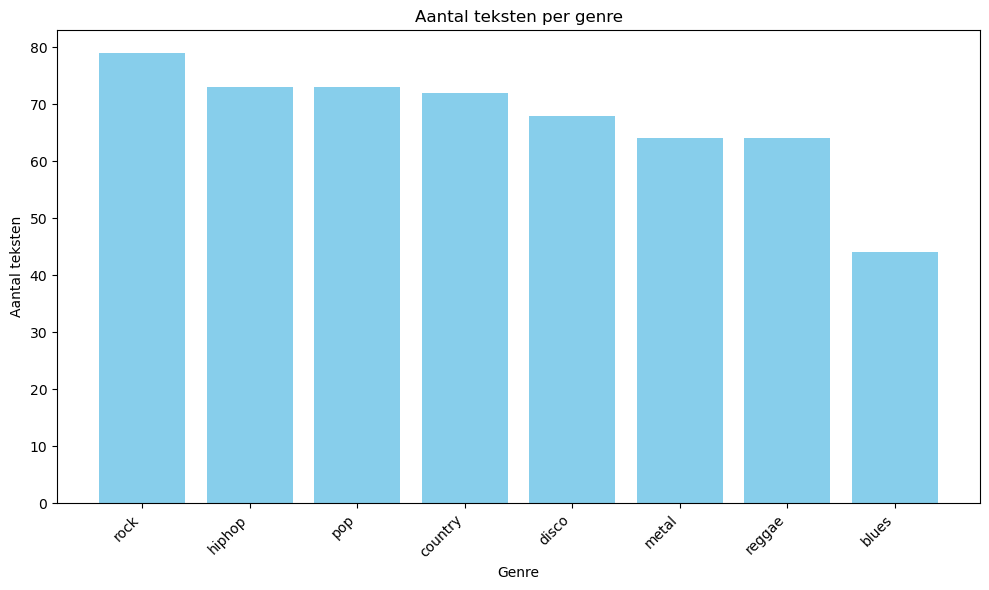

In [12]:
genres = tekst["genre"].value_counts().index
aantallen = tekst["genre"].value_counts().values

plt.figure(figsize=(10, 6))
plt.bar(genres, aantallen, color='skyblue')
plt.title('Aantal teksten per genre')
plt.xlabel('Genre')
plt.ylabel('Aantal teksten')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
tekst["lyrics"]

0      I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...
1      (John Lee Hooker)\nThink twice before you go, ...
2      [Intro, Spoken]\n...A little thing I'm going t...
3      Sugar mama, sugar mama, sugar mama please come...
4      My baby left me this morning\nPeople just arou...
                             ...                        
532    [Chorus]\nDon’t stop\nIsn’t it funny how you s...
533    [Verse 1]\nHer hair, soft drifted snow\nDeath ...
534    [Verse 1]\nYour knuckles whiten on the wheel\n...
535    [Verse 1]\nYou know it\nYou show it\nAnd the t...
536    [Verse 1]\nA girl consumed by fire\nWe all kno...
Name: lyrics, Length: 537, dtype: object

In [14]:
tekst['lyrics_length'] = tekst['lyrics'].apply(lambda x: sum(len(line) for line in x))
tekst

,filename,lyrics,genre,lyrics_length
0,blues.00001.wav,I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...,blues,706
1,blues.00002.wav,"(John Lee Hooker)\nThink twice before you go, ...",blues,755
2,blues.00003.wav,"[Intro, Spoken]\n...A little thing I'm going t...",blues,1456
3,blues.00005.wav,"Sugar mama, sugar mama, sugar mama please come...",blues,1318
4,blues.00006.wav,My baby left me this morning\nPeople just arou...,blues,713
...,...,...,...,...
532,rock.00094.wav,[Chorus]\nDon’t stop\nIsn’t it funny how you s...,rock,793
533,rock.00096.wav,"[Verse 1]\nHer hair, soft drifted snow\nDeath ...",rock,1155
534,rock.00097.wav,[Verse 1]\nYour knuckles whiten on the wheel\n...,rock,1214
535,rock.00098.wav,[Verse 1]\nYou know it\nYou show it\nAnd the t...,rock,1002


In [21]:
tekst_lens = tekst.groupby("genre")["lyrics_length"].mean()
tekst_lens

genre
blues       893.704545
country    2174.333333
disco      2699.058824
hiphop     4677.986301
metal      4417.203125
pop        2312.410959
reggae     1638.734375
rock       1274.594937
Name: lyrics_length, dtype: float64

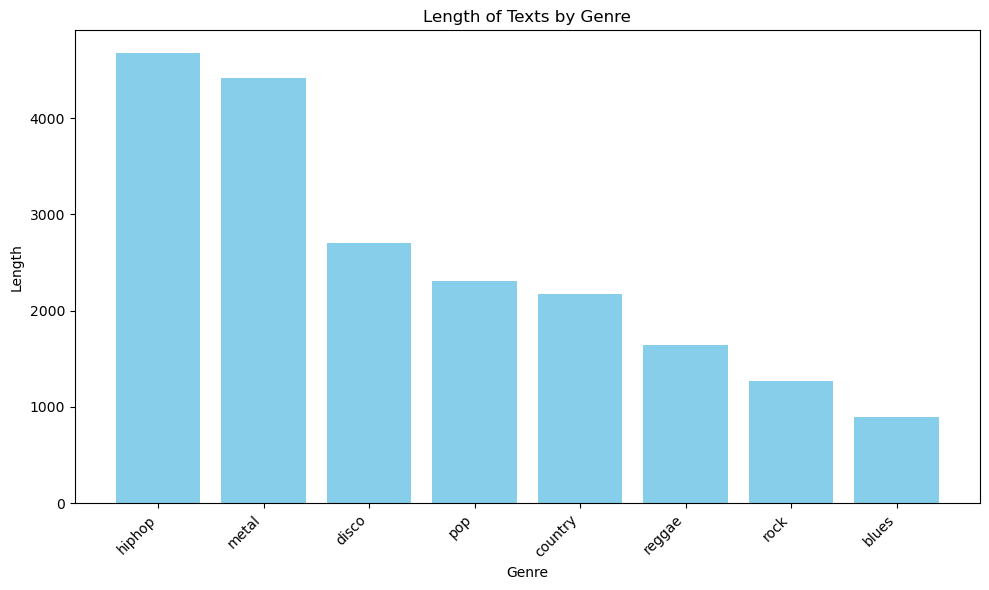

In [23]:
sorted_df = tekst_lens.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(sorted_df.index, sorted_df.values, color='skyblue')
plt.title('Length of Texts by Genre')
plt.xlabel('Genre')
plt.ylabel('Length')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Wanneer er gekeken wordt naar de gemiddelde lengtes van de teksten per genre valt het meteen op dat er een stuk meer tekst zit in liedjes met het genre hiphop en pop dan in liedjes als reggae, rock en blues. Het is goed om te zien dat hier zo'n groot verschil in zit, omdat dit hoop geeft op de voorspellingen die uiteindelijk gemaakt moeten worden.

<a name='2.4'></a>
<h3>&sect;2.4: Conclusie EDA</h3>

[Back to the top](#start)
<a name='3.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H3: LSTM voor audioclips</strong></h2>
</div>

<a name='3.1'></a>
<h3>&sect;3.1: Het model</h3>

<a name='3.2'></a>
<h3>&sect;3.2: Modelarchitectuur</h3>

<a name='3.3'></a>
<h3>&sect;3.3: Stappen feature engineering</h3>

<a name='3.4'></a>
<h3>&sect;3.4: Onderbouwing keuzes parameters</h3>

<a name='3.5'></a>
<h3>&sect;3.5: Geschikte loss functie en optimizer</h3>

<a name='3.6'></a>
<h3>&sect;3.6: Model trainen</h3>

[Back to the top](#start)
<a name='4.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H4: LSTM voor songteksten</strong></h2>
</div>

<a name='4.1'></a>
<h3>&sect;4.1: Het model</h3>

<a name='4.2'></a>
<h3>&sect;4.2: Modelarchitectuur</h3>

<a name='4.3'></a>
<h3>&sect;4.3: Onderbouwing keuzes parameters</h3>

<a name='4.4'></a>
<h3>&sect;4.4: Datapipeline met data preprocessing, feature engineering, of/en data
augmentation</h3>

<a name='4.5'></a>
<h3>&sect;4.5: Model trainen</h3>

[Back to the top](#start)
<a name='5.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H5: Transformer voor songteksten</strong></h2>
</div>

<a name='5.1'></a>
<h3>&sect;5.1: Het model</h3>

<a name='5.2'></a>
<h3>&sect;5.2: Fine-tuning Hugging Face</h3>

<a name='5.3'></a>
<h3>&sect;5.3: Naam modelarchitectuur en dataset</h3>

<a name='5.4'></a>
<h3>&sect;5.4: Voordelen vooraf getrainde tekstmodellen</h3>

<a name='5.5'></a>
<h3>&sect;5.5: Stappen finetunen vooraf getraind model en motivatie keuzes</h3>

[Back to the top](#start)
<a name='6.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H6: Model naar keuze</strong></h2>
</div>

<a name='6.1'></a>
<h3>&sect;6.1: Het model</h3>

<a name='6.2'></a>
<h3>&sect;6.2: Modelarchitectuur</h3>

<a name='6.3'></a>
<h3>&sect;6.3: Uitleg keuzes model</h3>

[Back to the top](#start)
<a name='7.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H7: Bevindingen</strong></h2>
</div>

<a name='7.1'></a>
<h3>&sect;7.1: Samenvatting van de uitkomsten</h3>

##### Geef een beknopt overzicht van de resultaten

##### Welke model presteert het beste? Bij welke parameters?

##### Toon je scores op Kaggle en laat zien wat de resultaten waren van je verbeteringen op je score op Kaggle.

[Back to the top](#start)
<a name='8.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H8: Conclusie en aanbevelingen</strong></h2>
</div>

<a name='8.1'></a>
<h3>&sect;8.1: Uitdagingen modelleringsproces</h3>

<a name='8.2'></a>
<h3>&sect;8.2: Prestaties modelarchitecturen</h3>

<a name='8.3'></a>
<h3>&sect;8.3: Beste modellen audio en tekst</h3>

<a name='8.4'></a>
<h3>&sect;8.4: Genres makkelijk te voorspellen met audio en tekst</h3>

<a name='8.5'></a>
<h3>&sect;8.5: Advies voor app</h3>

<a name='8.6'></a>
<h3>&sect;8.6: Conceptuele uitbreiding voor systeem</h3>

[Back to the top](#start)
<a name='9.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H9: Literatuurlijst</strong></h2>
</div>